---

# 다양한 딥러닝 기반 텍스트 분류 엔진 모델 및 API개발
(부제 : IT VOC 2선 분류 업무 자동화를 위한 AI 모델 개발)

- 개요 : \
IT VOC 프로세스 내에서는 1선 그룹에서 처리하지 못하는 VOC를 2선 그룹으로 넘겨 처리하고 있는데, 이 때 상담사가 경험 기반으로 VOC 내용을 판단해서 적절한 2선 그룹(183개 분류 그룹 중 하나)로 매핑하여 넘기고 있으며 건당 30초가 걸리는 이 수작업 과정을 자동화할 수 있도록, 구글에서 공개한 BERT(nlp pre-training 모델)을 참고하여 해당 업무에 Customized 된 AI 자동 분류 모델을 만드는 것입니다.

- 과제 배경 : \
.대리점 직원 또는 임직원이 고객의 요금, 해지 등 업무 처리를 위해 사내 IT 전산(KOS 등)을 활용하는데 시스템 상의 처리 오류 등 문제가 발생한 경우, ITSM이나 IT 콜센터로 VOC를 접수하게 됩니다. \
.이렇게 들어온 VOC는 상담사가 1선 처리 그룹으로 해당 VOC를 매핑하여 해결토록 합니다. 보통 처리 방법이 명확한 접수 사항은 문제없이 1선에서 해결되지만, 당장 처리가 불가하거나 보류가 필요한 VOC의 경우에는 2선(또는 1.5선) 처리 그룹으로 매핑하여 넘기고 있습니다. \
.이 때 상담사가 2선 처리 그룹으로 넘길 때, 본인의 경험을 바탕으로 VOC 내용을 판단하여 183개 처리 그룹 중 하나로 매핑하여 넘기고 있으며, 처리그룹명이 길고 복잡하다 보니 건 당 약 30초의 시간이 소요되고 있어 업무 처리 효율이 떨어지는 문제점이 있고, 또 휴먼에러로 인해 매핑에 실패할 경우 VOC가 핑퐁되고 재매핑되어 처리 시간이 길어지게 되어 고객의 불만이 높아지는 사태가 발생할 수 있습니다. \
.본 과제를 통해서 IT VOC 프로세스에 'AI를 활용한 2선 분류 자동화 모델'이 적용이 된다면 사람 경험에 따른 불규칙하고 비효율적인 처리 방식에서 AI모델을 통한 일관되고 효율적인 VOC 처리를 통해 상담사, 고객 모두 만족도가 높아질 것이라 기대합니다. 

(사진: 상담 프로세스 넣기)

- 과제 목표 : \
상담 내용(text) 기반으로 2선 처리 그룹 분류 정확도 Top1 기준 80% 이상 달성 
> 작년 PO부서의 모델의 분류 정확도 : 77.9% 

- 과제 내용 : \
자연어처리 최신 기법인 Transfer Learning(BERT 등)을 통해 분류 task의 성능을 높일 수 있도록 다각도로 연구해보고, 추가로 연구 성능을 높일 수 있는 다양한 시도를 했던 과정을 기록하였습니다.

---

<br>

## 1. 데이터 탐색


#### (1) Data 불러오기

    ㅇ 대상 : IT VOC 상담 처리 데이터 
    ㅇ 기간 : 2018.07 ~ 2019.05 (11개월) 
    
    * 작년 PO부서에서 과제 진행시 사용한 데이터를 활용 하였습니다. (동일한 test set 기준으로 성능 비교 예정)

In [ ]:
import numpy as np
import pandas as pd

# 전달받은 원본 그대로 load
# 1) 전체 data 불러오기 
data_2018_1 = pd.read_csv('data/data_all/2018_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_2 = pd.read_csv('data/data_all/2018_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_3 = pd.read_csv('data/data_all/2018_sheet3.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_4 = pd.read_csv('data/data_all/2018_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_5 = pd.read_csv('data/data_all/2018_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_1 = pd.read_csv('data/data_all/2019_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_2 = pd.read_csv('data/data_all/2019_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_3 = pd.read_csv('data/data_all/2019_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_4 = pd.read_csv('data/data_all/2019_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )

# 합치기 (원천데이터이며 이안에 test data도 포함되어 있기에 제외작업 필요)
data_all = pd.concat([data_2018_1,data_2018_2,data_2018_3,data_2018_4,data_2018_5,data_2019_1,data_2019_2,data_2019_3,data_2019_4],axis=0)


# 2) 작년 po부서에서 정확도 산정에 쓰인 test set 불러오기 
test = pd.read_table('data/data_all/test.tsv' ,sep = "\t" ,encoding='utf-8',header=None) # 서비스문의ID 와 제목+내용 컬럼 존재
test.columns = ['id','content']
test_label = pd.read_table('data/data_all/solution.tsv', sep = "\t" ,encoding='utf-8' ,header=None) # 서비스문의ID 와 최종처리그룹 컬럼 존재
test_label.columns = ['id','label']

<br><br>
#### (2) Data 관찰
   - 아래와 같이 서비스문의ID ~ 작업그룹명까지 18개의 컬럼이 있고, 이 중 <code>'최종처리그룹'</code>이 예측 해야하는 **결과값(y)** 입니다.
   - 예측방법으로 NLP task를 사용할 것이며, <code>'제목'</code> 과 <code>'내용'</code> 의 text data를 **입력값(X)** 으로 사용하게 됩니다.
   - 전달받은 데이터는 56만건 이며, 이는 '최종 지원 단계' 1선과 2선이 포함된 데이터 입니다. 2선 데이터를 대상으로 분석이 진행됩니다.

In [5]:
pd.set_option('display.max.colwidth', 50)
data_all.head(1)

,서비스문의 ID,도메인ID,서비스,등록일,요청자ID,요청자부서ID,제목,내용,문의유형 Level1,문의유형 Level2,VOC코드1,VOC코드2,VOC코드3,최종 지원 단계,최종처리그룹,최종처리그룹명,작업그룹,작업그룹명
0,SRM18070179909,COD_03825,BG0117,2018-07-01,91165856,NaN,고객님 정보 확인 불가 문의,안녕하세요.\r\n당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지...,불만문의,DB보정,VCA00948,VCB04356,VCC12278,2선,ASM34824,KOS-오더_KOS-Customer_CDM-통합UI_서비스요청_2선,ASM34886,ISC_서비스요청_KOS_Mobile_B2C_1선


In [3]:
data_all.shape # 총 56만건 데이터, 18개 컬럼

(564319, 18)

In [10]:
data_all['최종 지원 단계'].value_counts() # 1선 : 48만건 , 2선 : 4.5만건 , 1.5선 : 3만건 
data_all['최종 지원 단계'].value_counts()/data_all['최종 지원 단계'].count()*100  # 1선 : 86% , 2선 : 8% , 1.5선 : 약6% 해당

1선          86.094867
2선           8.076816
1.5선         5.828139
ASM30005     0.000179
Name: 최종 지원 단계, dtype: float64

> 1선 : 약 48만 건 (86%) \
> 1.5~2선 : 약 8만 건 (14%)


<br><br>
#### (3) Train Data Frame 저장
  
    1. 전체 56만건 중에서 Test Set의 '최종처리그룹' 183개 label을 대상으로 추립니다.
    2. Test Set에 사용된 8327개의 '서비스문의ID'는 제외합니다. (학습시 test 데이터는 포함하면 안됨) 


In [3]:
# 1) 56만건 중 Test Set에 있는 '최종처리그룹'만 선택
print('test의 최종처리그룹(y) 개수 :', test_label.label.nunique(),'개' )  # 183
lb_183 = test_label.label.unique() 
data_sub = data_all.loc[data_all['최종처리그룹'].isin(lb_183) , :]
print('처리 후 데이터 shape :', data_sub.shape )  # (42723, 18)

test의 최종처리그룹(y) 개수 : 183 개
처리 후 데이터 shape : (42723, 18)


In [4]:
# 2) 56만건 중 Test Set의 '서비스문의ID' 제거
print('test의 서비스문의 ID 개수 :', test.id.nunique(), '개' )  # 8327
test_id = test.id.unique() 
df_train = data_sub.loc[~data_sub['서비스문의 ID'].isin(test_id),:] 
print('처리 후 데이터 shape :', df_train.shape )  # (34396, 18)

test의 서비스문의 ID 개수 : 8327 개
처리 후 데이터 shape : (34396, 18)


In [5]:
# 3) 저장 (추후 daraframe 으로 불러오기용)
df_train.to_csv('train_df.tsv', index=False, header=True, sep="\t")

> 최종 Train Data Frame : df_train \
> dt_train 데이터 건수 : 34,396

<br><br>
#### (4) Test Data Frame 저장
  
    1. 전체 56만건 중 Test Set의 같은 '서비스문의ID'로 선별합니다.
    

In [8]:
# 56만건 중 Test Set의 동일 '서비스문의ID' 저장
print('원본 Test Set shape :', test.shape )  # (34396, 2)
df_test = data_sub.loc[data_sub['서비스문의 ID'].isin(test_id) , :]
print('처리 후 데이터 shape :', df_test.shape )  # (34396, 18)
print('\n ▶ 원본 Test Set 과 df_test 데이터 총 행 개수 동일')

원본 Test Set shape : (8327, 2)
처리 후 데이터 shape : (8327, 18)

 ▶ 원본 Test Set 과 df_test 데이터 총 행 개수 동일


In [9]:
# 저장 (추후 daraframe 으로 불러오기용)
df_test.to_csv('test_df.tsv', index=False, header=True, sep="\t")

> 최종 Test Data Frame : df_test \
> df_test 데이터 건수 : 8,327

<br><br>
#### (5) Data 결측치 여부
  
   - Train data 와 Test data의 결측치 여부를 확인합니다.
   - 타겟 컬럼 : <code>제목</code>, <code>내용</code>, <code>최종처리그룹</code>
    

In [10]:
target_col = ['제목', '내용', '최종처리그룹']
print('Train data 결측치 개수 :', sum([df_train[col].isnull().sum() for col in target_col]))
print('Test data 결측치 개수 :', sum([df_test[col].isnull().sum() for col in target_col]))

Train data 결측치 개수 : 0
Test data 결측치 개수 : 0


<br><br>
#### (6) 최종처리그룹(y) Label 살펴보기
  
    1. Train data 와 Test data의 label 개수를 비교합니다.
    2. label(레이블)별 데이터가 고르게 분포되어 있는지 그래프를 통해 확인합니다.

In [11]:
# 1) Train data 와 Test data의 label 개수 비교
print('Train의 최종처리그룹(y) 개수 :', df_train.최종처리그룹.nunique(), '개' )
print('Test의 최종처리그룹(y) 개수 :', df_test.최종처리그룹.nunique(), '개 \n' )

Train의 최종처리그룹(y) 개수 : 175 개
Test의 최종처리그룹(y) 개수 : 183 개 



In [12]:
print('Test 레이블 개수가 Train의 레이블 개수 보다', df_test.최종처리그룹.nunique() - df_train.최종처리그룹.nunique(), '개 많습니다.' )
print('해당 레이블 (8개) : ',list(set(df_test['최종처리그룹']) - set(df_train['최종처리그룹'])))
ex_labels = list(set(df_test['최종처리그룹']) - set(df_train['최종처리그룹']))

print('Test data 내 해당 8개의 레이블이 차지하는 데이터의 건수를 확인 합니다.')
print(' ->',df_test.loc[df_test.최종처리그룹.isin(ex_labels),:].shape[0],'건')
print(df_test.loc[df_test.최종처리그룹.isin(ex_labels),:].shape[0],'건은 전체 test data(8327건)의'
      ,round(df_test.loc[df_test.최종처리그룹.isin(ex_labels),:].shape[0]/df_test.shape[0]*100,1),'%에 해당합니다.')

Test 레이블 개수가 Train의 레이블 개수 보다 8 개 많습니다.
해당 레이블 (8개) :  ['ASM30358', 'ASM39559', 'ASM37580', 'ASM18770', 'ASM37550', 'ASM14444', 'ASM30366', 'ASM40270']
Test data 내 해당 8개의 레이블이 차지하는 데이터의 건수를 확인 합니다.
 -> 9 건
9 건은 전체 test data(8327건)의 0.1 %에 해당합니다.


> 9건을 삭제한다면 정확도(accuracy) 향상에 유리하겠지만, \
8개의 해당 label을 test set에서 삭제하지 않았습니다. \
> 이유는, 미래의 데이터에는 해당 9개의 레이블을 정답으로 하는 VOC가 발생할 수 있기 때문입니다.


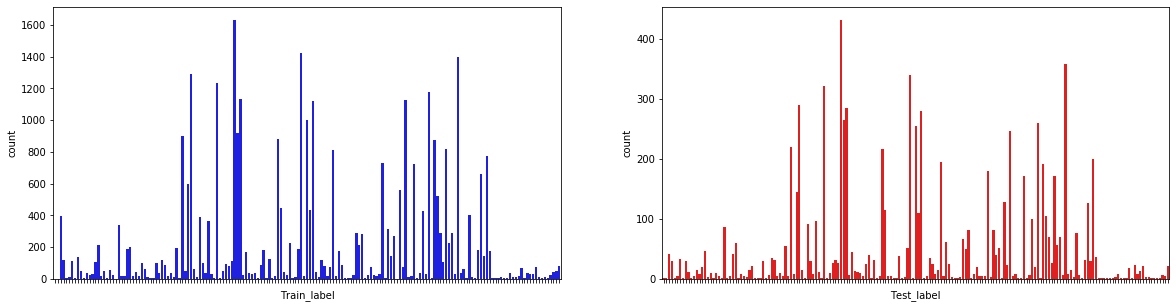

In [128]:
# 2) label(레이블)별 데이터 빈도 확인 
import matplotlib.pyplot as plt
import seaborn as sns 
train_lb = pd.DataFrame(df_train['최종처리그룹'].value_counts())
train_lb = train_lb.reset_index()
train_lb.columns = ['Train_label','count']
test_lb = pd.DataFrame(df_test['최종처리그룹'].value_counts())
test_lb = test_lb.reset_index()
test_lb.columns = ['Test_label','count']

# 그래프
f, axes = plt.subplots(1, 2, figsize=(20, 5))
fig_1 = sns.barplot(x='Train_label', y="count", data=train_lb.sort_values(by='Train_label'), ax=axes[0],color="blue").set(xticklabels=[])
fig_2 = sns.barplot(x='Test_label', y="count", data=test_lb.sort_values(by='Test_label'), ax=axes[1],color="red").set(xticklabels=[])
# plt.tight_layout(pad=3.0)
# test_lb

> Train / Test data의 label 별 데이터가 분포가 불균형 합니다. \
> 데이터가 많은 label은 정답률이 높을 것이고, 데이터가 부족한 label은 그렇지 못할 것으로 예상됩니다. (추후 데이터 추가 보완이 필요해 보임)


In [127]:
# 2) label(레이블)별 데이터 빈도 확인
train_lb.columns = ['Labels','Train_Cnt']
test_lb.columns = ['Labels','Test_Cnt']

pd.merge(test_lb, train_lb, on = 'Labels', how='left')

,Labels,Test_Cnt,Train_Cnt
0,ASM30031,431,1631.0
1,ASM38968,358,1398.0
2,ASM30565,339,1424.0
3,ASM30014,321,1233.0
4,ASM24663,290,1291.0
...,...,...,...
178,ASM40270,1,NaN
179,ASM39556,1,4.0
180,ASM14261,1,2.0
181,ASM14307,1,3.0


> <code>ASM14261, ASM14307, .. </code> 경우 처럼 train 데이터가 10건 미만의 경우, 학습할 정보가 부족해 정답을 맞출 확률이 낮을 것으로 예상됩니다.

<br><br><br>

## 1-2. 데이터 전처리

   - Train/Test 데이터를 BERT 모델에 적용할 수 있는 Input(X), Output(y) 데이터로 재구성 합니다.
    >Input (X) : '제목' + '내용' (text) \
    >Output (y) : '최종처리그룹' (label)
    

#### (1) Input (X) : 제목+내용 합친 후, 특수문자 제거

In [158]:
print('Train Data 개수 :',df_train.shape[0] , '\nTest Data 개수 :',df_test.shape[0])
df_train[['제목','내용','최종처리그룹']].head(3)
df_test[['제목','내용','최종처리그룹']].head(3)

Train Data 개수 : 34396 
Test Data 개수 : 8327


,제목,내용,최종처리그룹
6,인터넷 신청 자동문자 발송여부 확인 부탁드립니다.,안녕하세요~\r\n상담품질컨설팅센터 입니다.\r\n인터넷 신청 자동문자 발송여부 확...,ASM14326
40,KOS / 인터넷 bus333584 외 87개회선 / 인터넷 일괄해지 접수했는데 해...,▶[시스템] ***\r\n▶[데이터] 인터넷 ********* 외 **개\r\n▶[...,ASM30034
149,유선에서 무선으로 변경 후 로그인 안됨 문의,유선에서 무선으로 변경 후 로그인 안됨 문의\r\n****_** 프로필 재설정해도 ...,ASM30014


In [14]:
# 1) 제목+내용을 한줄로 합치기 
title_tr = df_train.제목.tolist()
contents_tr = df_train.내용.tolist()
temp_tr = zip(title_tr,contents_tr)
train_text = list(map(lambda x: str(x[0]) + ' ' + str(x[1]), temp_tr))  
train_text[0]

title_te = df_test.제목.tolist()
contents_te = df_test.내용.tolist()
temp_te = zip(title_te,contents_te)
test_text = list(map(lambda x: str(x[0]) + ' ' + str(x[1]), temp_te))   

print('Train text 개수 :',len(train_text) , '\nTest text 개수 :',len(test_text))
print('\n▶ 제목과 내용을 합친 처리 결과 예시 :')
test_text[0]

Train text 개수 : 34396 
Test text 개수 : 8327

▶ 제목과 내용을 합친 처리 결과 예시 :


'인터넷 신청 자동문자 발송여부 확인 부탁드립니다. 안녕하세요~\r\n상담품질컨설팅센터 입니다.\r\n인터넷 신청 자동문자 발송여부 확인 부탁드립니다. \r\n\r\n* 서비스번호+계약자명 : ****-****-**** / 고영이\r\n* 휴대폰번호 : ***-****-****\r\n* 접수센터+접수자명 : 대전 / 박다래 컨설턴트\r\n* 접수일+상품 : */**일 / 인터넷 신청\r\n\r\n* ***-****-**** 번으로 발송이력 없다면 다른 번호로 발송된 이력 있는지 여부도 확인 부탁드립니다.'

In [15]:
# 2) 텍스트 특수문자 제거하기
# 1. 한글, 영어대문자,소문자 남기고 나머지 삭제 (숫자의 경우 전화번호 사례가 많아 삭제) (한글의 경우 자음/모음으로만 이뤄진 ㅎㅎ ㅜㅜ 단어 삭제)
# 2. 영어대문자는 소문자로 통일 (컴퓨터는 KOS, kos 를 다르게 인식)

import re

# train texts 전처리 및 리스트화
train_x =[]

for i in train_text:
    i = re.sub('[^가-힣a-zA-Z]',' ',i).strip().lower() # 영어 소문자화 : lower() , 한글과 영문만 남기고 삭제
    pattern = re.compile(r'\s\s+')
    temp = re.sub(pattern, ' ', i)
    train_x.append(temp)
    
# test texts 전처리 및 리스트화
test_x =[]

for i in test_text:
    i = re.sub('[^가-힣a-zA-Z]',' ',i).strip().lower() # 영어 소문자화 : lower() , 한글과 영문만 남기고 삭제
    pattern = re.compile(r'\s\s+')
    temp = re.sub(pattern, ' ', i)
    test_x.append(temp)
    
# print('Train text 개수 :',len(train_x) , '\nTest text 개수 :',len(test_x))
print('\n▶ 특수문자 제거 등 텍스트 전처리 처리 결과 예시 :')
test_x[0]




▶ 특수문자 제거 등 텍스트 전처리 처리 결과 예시 :


'인터넷 신청 자동문자 발송여부 확인 부탁드립니다 안녕하세요 상담품질컨설팅센터 입니다 인터넷 신청 자동문자 발송여부 확인 부탁드립니다 서비스번호 계약자명 고영이 휴대폰번호 접수센터 접수자명 대전 박다래 컨설턴트 접수일 상품 일 인터넷 신청 번으로 발송이력 없다면 다른 번호로 발송된 이력 있는지 여부도 확인 부탁드립니다'

> 최종 이용하게 될 Input(x) : train_x , test_x

<br><br>

#### (2) Output (y) : 최종처리그룹 (label)

In [185]:
# train/test labels 리스트화
train_y = df_train.최종처리그룹.tolist()
test_y = df_test.최종처리그룹.tolist()
test_y[:3]

['ASM14326', 'ASM30034', 'ASM30014']

> 최종 이용하게 될 Output(y) : train_y , test_y

<br><br>
#### (3) 데이터 저장 (.tsv)
- 다양한 NLP Task 모델에 적용할 수 있도록 <code>label</code>, <code>text</code> 로 최종 저장 

    ㅇ Input(x) : train_x , test_x \
    ㅇ Output(y) : train_y , test_y

In [187]:
import pandas as pd

df_tr = pd.DataFrame(train_y) 
df_tr['text'] =train_x
df_tr.columns= ['label' , 'text']
df_tr.head(5)

df_tst = pd.DataFrame(test_y) 
df_tst['text'] =test_x
df_tst.columns= ['label' , 'text']
df_tst.head(5)

,label,text
0,ASM14326,인터넷 신청 자동문자 발송여부 확인 부탁드립니다 안녕하세요 상담품질컨설팅센터 입니다...
1,ASM30034,kos 인터넷 bus 외 개회선 인터넷 일괄해지 접수했는데 해지오더가 들어가지 않고...
2,ASM30014,유선에서 무선으로 변경 후 로그인 안됨 문의 유선에서 무선으로 변경 후 로그인 안됨...
3,ASM34860,kos 일반전화 캠페인수행건 삭제 및 재등록 불가하여 문의 시스템 데이터 일반전화 ...
4,ASM30031,재문의 srm kos 인터넷전화 설변오더 등록한 처리자 문의 재문의 인터넷전화 설변...


In [188]:
# tsv 파일로 저장 
df_tr.to_csv('data/train_data.tsv', index=False, header=True, sep="\t")
df_tst.to_csv('data/test_data.tsv', index=False, header=True, sep="\t")

- 이후 bert 적용 시, train_data.tsv, test_data.tsv 를 사용하여 진행할 예정입니다.

In [19]:
# 파일 읽기 형태
pd.read_csv('data/test_data.tsv',sep="\t")

,label,text
0,ASM14326,인터넷 신청 자동문자 발송여부 확인 부탁드립니다 안녕하세요 상담품질컨설팅센터 입니다...
1,ASM30034,kos 인터넷 bus 외 개회선 인터넷 일괄해지 접수했는데 해지오더가 들어가지 않고...
2,ASM30014,유선에서 무선으로 변경 후 로그인 안됨 문의 유선에서 무선으로 변경 후 로그인 안됨...
3,ASM34860,kos 일반전화 캠페인수행건 삭제 및 재등록 불가하여 문의 시스템 데이터 일반전화 ...
4,ASM30031,재문의 srm kos 인터넷전화 설변오더 등록한 처리자 문의 재문의 인터넷전화 설변...
...,...,...
8322,ASM31688,긴급 kos 유선에는 기가지니상품이나 작업의뢰서는 일반otv로 확인됨 경로 서비스지...
8323,ASM38958,무선 그린폰포인트 원복요청 월 일 고객님 개통취소를 위한 그린폰 포인트수납취소요청을...
8324,ASM38968,가입제한 해제 요청 강현자 해지 해당 회선 스팸이용정지 후 정지미복구 상태로 해지하...
8325,ASM38933,자동이체 출금요청들어가지 않은사유 경로 데이터 최희진 청구번호 계좌번호 지역농축협 ...


<br><br><br>
####  lessons learned


- 정규표현식을 사용하여 전처리를 진행하며 시행착오를 겪었습니다.
- 특수문자를 선별적으로 제거하다보니 생각치못한 특수문자 사용예가 있어 한글과 영어를 제외한 모든 특수문자를 날리는 방법으로 진행해야 했습니다.
- KOS, kos는 컴퓨터는 다른 단어로 인식하기에 영문은 소문자화 진행해야 했습니다.

<br><br><br><br><br><br><br>
<hr>

작성자 : 박은진